In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
api = KaggleApi()
api.authenticate()

In [3]:
api.competition_download_file(
    "sentiment-analysis-on-movie-reviews", "train.tsv.zip", path="./"
)

train.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import zipfile

with zipfile.ZipFile("train.tsv.zip", "r") as zipref:
    zipref.extractall("./")

In [8]:
import sys

print(sys.path)

['/Users/alexandros/Documents/Repos/transformer-sequence-classification', '/Users/alexandros/miniforge3/envs/tensorflow/lib/python39.zip', '/Users/alexandros/miniforge3/envs/tensorflow/lib/python3.9', '/Users/alexandros/miniforge3/envs/tensorflow/lib/python3.9/lib-dynload', '', '/Users/alexandros/miniforge3/envs/tensorflow/lib/python3.9/site-packages', '/Users/alexandros/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tokenizers-0.11.4-py3.9-macosx-11.1-arm64.egg', '/Users/alexandros/miniforge3/envs/tensorflow/lib/python3.9/site-packages/IPython/extensions', '/Users/alexandros/.ipython']


In [12]:
sys.path.append(
    "/Users/alexandros/Documents/Repos/transformer-sequence-classification/venv/lib/python3.9/site-packages/"
)

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from math import ceil
from transformers import AutoTokenizer, TFAutoModel

In [16]:
df = pd.read_csv("train.tsv", sep="\t")

In [17]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [18]:
df.drop_duplicates(subset="SentenceId", keep="first", inplace=True, ignore_index=True)
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,64,2,"This quiet , introspective and entertaining in...",4
2,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
3,117,4,A positively thrilling combination of ethnogra...,3
4,157,5,Aggressive self-glorification and a manipulati...,1


In [19]:
len(df)

8529

In [20]:
seqlen = df["Phrase"].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='Phrase', ylabel='Count'>

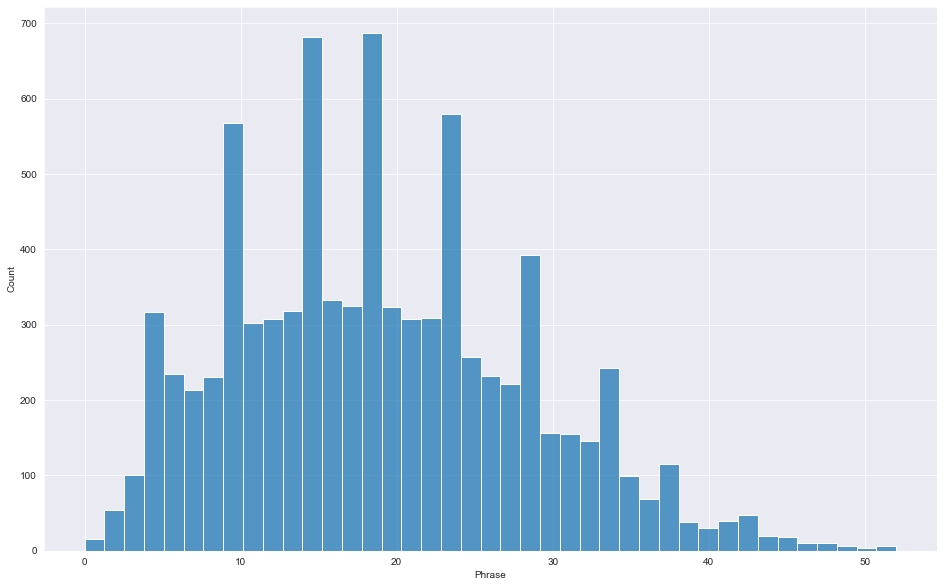

In [23]:
sns.set_style("darkgrid")
plt.figure(figsize=(16, 10))
sns.histplot(seqlen)

#### Encode Data

In [24]:
SEQ_LEN = 50

In [32]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [36]:
tokens = tokenizer.encode_plus(
    "hello world",
    max_length=50,
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=True,
    return_tensors="tf",
)

Init Plugin


2022-12-27 13:39:21.438093: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.


Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1 Pro


2022-12-27 13:39:21.438310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [38]:
tokens

{'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[  101, 19082,  1362,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [62]:
tokens = tokenizer.batch_encode_plus(
    df["Phrase"].to_list(),
    max_length=50,
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=True,
    return_tensors="tf",
)

In [64]:
Xids, Xmask = tokens["input_ids"], tokens["attention_mask"]

In [74]:
sentiment_arr = df["Sentiment"].values

labels = np.zeros((sentiment_arr.size, sentiment_arr.max() + 1), dtype=int)

# replacing 0 with a 1 at the index of the original array
labels[np.arange(sentiment_arr.size), sentiment_arr] = 1

In [75]:
labels

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [77]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [79]:
for i in dataset.take(1):
    print(i)

(<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([  101,   138,  1326,  1104, 13936, 25265, 16913, 15107,  1103,
        8050,  2553,  1115,  1184,  1110,  1363,  1111,  1103, 20398,
        1110,  1145,  1363,  1111,  1103,   176,  9900,   117,  1199,
        1104,  1134,  5411,  1821, 14225,  1133,  3839,  1104,  1134,
        7919,  1106,  1277,  1104,   170,  1642,   119,   102,     0,
           0,     0,     0,     0,     0], dtype=int32)>, <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0], dtype=int32)>, <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 0, 0, 0])>)


TensorFlow expects input data as Dataset to be in tuple format. Where 0 index is input values and 1 is labels. We are using 2 inputs so within input we need to have a dictionary.

In [80]:
def map_func(input_ids, masks, labels):
    return {"input_ids": input_ids, "attention_mask": masks}, labels

In [81]:
dataset = dataset.map(map_func)

In [82]:
for i in dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([  101,   138,  1326,  1104, 13936, 25265, 16913, 15107,  1103,
        8050,  2553,  1115,  1184,  1110,  1363,  1111,  1103, 20398,
        1110,  1145,  1363,  1111,  1103,   176,  9900,   117,  1199,
        1104,  1134,  5411,  1821, 14225,  1133,  3839,  1104,  1134,
        7919,  1106,  1277,  1104,   170,  1642,   119,   102,     0,
           0,     0,     0,     0,     0], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0], dtype=int32)>}, <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 0, 0, 0])>)


2022-12-27 19:29:37.370875: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-27 19:29:37.371844: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [98]:
BATCH_SIZE = 32

In [99]:
dataset.shuffle(10_000).batch(BATCH_SIZE)

<BatchDataset shapes: ({input_ids: (None, 50), attention_mask: (None, 50)}, (None, 5)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int64)>

In [88]:
DS_LEN = dataset.cardinality().numpy()

In [101]:
NO_BATCHES = ceil(DS_LEN / 32)
NO_BATCHES

267

In [102]:
SPLIT = 0.9

train = dataset.take(round(NO_BATCHES * SPLIT))
val = dataset.skip(round(NO_BATCHES * SPLIT))

In [106]:
bert = TFAutoModel.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#### Build Model

Define the input layers

In [109]:
# Attention, name needs to be the same as in previously defined dict
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name="input_ids", dtype="int32")
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name="attention_mask", dtype="int32")

Bert takes in two inputs and returns 3 outputs from last layer of Bert model. The second tensor is the pooler output (last hidden state ran over activation function and then pooled - can be used directly for classification) which we're going to ignore.

In [129]:
embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation="relu")(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation="relu")(X)
y = tf.keras.layers.Dense(5, activation="softmax")(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [132]:
model.layers[2].trainable = False

In [133]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[3][0]          